<a href="https://colab.research.google.com/github/sm1899/Ml-algos-from-Scratch/blob/main/Transformer/audio_transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing the requirements
print('Installing Requirements... ',end='')
!pip install lightning
!pip install wandb
print('Done')


Installing Requirements... Collecting lightning
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
Done


In [ ]:
print('Importing Libraries... ', end='')

import os
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, Subset
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import wandb
import numpy as np
from torch.utils.checkpoint import checkpoint
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
import torch.nn.init as init
import torch.nn.utils as nn_utils
import gc
import seaborn as sns
import matplotlib.pyplot as plt


print('Done')


Importing Libraries... Done


In [ ]:
# Set device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract data
with zipfile.ZipFile("/content/drive/MyDrive/Archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
# Loading dataset
path = Path('/content/')
df = pd.read_csv('/content/meta/esc50.csv')

In [ ]:
df.columns

Index(['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take'], dtype='object')

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


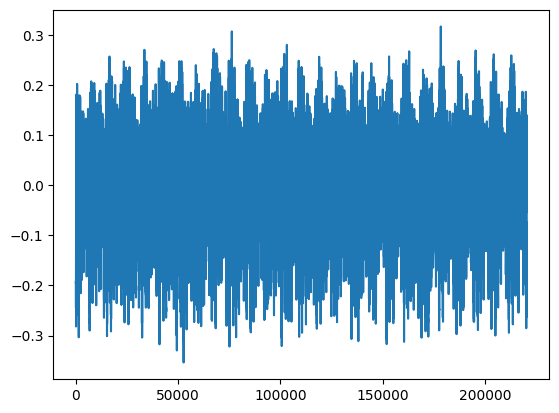

In [ ]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(wavs[0])  # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {}".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


# Helper Functions


In [ ]:
# to check for vanishing gradient
l = []
def print_gradients(model, threshold=1e-5):
    for name, param in model.named_parameters():
        if param.grad is not None and param.grad.norm() < threshold:
            l.append(f'Layer: {name}, Gradient norm: {param.grad.norm()}')

In [ ]:
# Training function
def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0.0
    correct_predictions = 0

    for inputs, labels in dataloader:

        inputs, labels = inputs.to(device), labels.to(device)

#         print(inputs.shape,labels.shape)


        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()

        # Print gradients below a certain threshold
        print_gradients(model, threshold=1e-5)

#         # Gradient clipping
#         max_grad_norm = 0.8  # Set your desired maximum gradient norm
#         nn_utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)

    # print("epoch", epoch, "train_loss", avg_loss, "train_accuracy", accuracy)

    wandb.log({"epoch": epoch, "train_loss": avg_loss, "train_accuracy": accuracy})
    return accuracy, avg_loss


# Validation function
def validate(model, dataloader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)



    # print("epoch", epoch, "val_loss", avg_loss, "val_accuracy", accuracy)

    wandb.log({"epoch": epoch, "val_loss": avg_loss, "val_accuracy": accuracy})

    return accuracy, avg_loss


# Test function
def test(model, dataloader, num_classes=10):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    confusion = confusion_matrix(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    print("Test Accuracy:", accuracy)
    print("F1 Score:", f1)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Convert labels to one-hot encoding for multi-class ROC curve
    true_one_hot = label_binarize(all_labels, classes=range(num_classes))

    # Compute micro-average ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_one_hot.ravel(), np.array(all_probs).ravel())
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Model")
    roc_display.plot()

    # Plot ROC curve for each class
    for i in range(num_classes):
        fpr_i, tpr_i, _ = roc_curve(true_one_hot[:, i], np.array(all_probs)[:, i])
        roc_auc_i = auc(fpr_i, tpr_i)
        plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {roc_auc_i:.2f})")

    plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


# Data Preparation

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(path, format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [ ]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        examples = torch.stack(examples).squeeze()
        labels = torch.flatten(torch.tensor(labels))

        return [examples, labels]


In [ ]:
# Data Setup
test_samp = 1 #  """ Do not change this!! """
valid_samp = 4 # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
batch_size = 32 # Free to change
num_workers = 2 # Free to change
custom_data_module = CustomDataModule(batch_size=batch_size,
                                      num_workers=num_workers,
                                      data_directory=path,
                                      data_frame=df,
                                      validation_fold=valid_samp,
                                      testing_fold=test_samp,  # set to 0 for no test set
                                      esc_10_flag=True,
                                      file_column='filename',
                                      label_column='category',
                                      sampling_rate=44100,
                                      new_sampling_rate=16000,  # new sample rate for input
                                      sample_length_seconds=1  # new length of input in seconds
                                      )

custom_data_module.setup()


100%|██████████| 80/80 [00:00<00:00, 7376.38it/s]


In [ ]:
# Data Exploration
print('Class Label: ', custom_data_module.training_dataset[0][1])  # this prints the class label
print('Shape of data sample tensor: ', custom_data_module.training_dataset[0][0].shape)  # this prints the shape of the sample (Frames, Channel, Features)


Class Label:  7
Shape of data sample tensor:  torch.Size([9, 1, 16000])


In [ ]:
batch = next(iter(custom_data_module.train_dataloader()))
input_tensor, label_tensor = batch

# Print the shapes
print("Input Tensor Shape:", input_tensor.shape)
print("Label Tensor Shape:", label_tensor.shape)


Input Tensor Shape: torch.Size([32, 9, 16000])
Label Tensor Shape: torch.Size([32])


# Architecture 1

In [ ]:
import torch.nn as nn
import torch.nn.init as init

class Conv1DClassifier(nn.Module):
    def __init__(self, in_channels, conv_channels, conv_kernel_sizes, conv_strides, fc_hidden_size, num_classes):
        super(Conv1DClassifier, self).__init__()

        # Convolutional Blocks
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels if i == 0 else conv_channels[i - 1],
                          conv_channels[i], conv_kernel_sizes[i], conv_strides[i]),
                nn.BatchNorm1d(conv_channels[i]),
                nn.LeakyReLU(0.1),
                nn.AvgPool1d(kernel_size=2, stride=2)
            )
            for i in range(len(conv_channels))
        ])

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(255616, fc_hidden_size),
            nn.BatchNorm1d(fc_hidden_size),
            nn.LeakyReLU(0.1),
            nn.Dropout(.3),
            nn.Linear(fc_hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(.3),
            nn.Linear(64, num_classes)
        )

        # Apply weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):
        # Convolutional Blocks
        for conv_block in self.conv_blocks:
            x = conv_block(x)

        # Fully Connected Layers
        x = self.fc_layers(x)

        return x


In [ ]:
in_channels =   9
conv_channels = [32, 64, 128]
conv_kernel_sizes = [8, 5, 3]
conv_strides = [1, 1, 1]
fc_hidden_size = 64
num_classes = 10

# Create an instance of the CustomConv1DNetwork
model_1 = Conv1DClassifier(in_channels, conv_channels, conv_kernel_sizes, conv_strides, fc_hidden_size, num_classes)

# Dummy input tensors
input_tensor = torch.randn((32, 9, 16000)).to(device)
model_1 = model_1.to(device)

output = model_1(input_tensor)
print(output.shape)


# # Print the model architecture
print(model_1)

torch.Size([32, 10])
Conv1DClassifier(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv1d(9, 32, kernel_size=(8,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Lin

In [ ]:
criterion = nn.CrossEntropyLoss()

# Define  optimizer
optimizer = optim.Adam(model_1.parameters(), lr=0.001)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

epochs = 25


In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Set up WandB
wandb.init(project="arch_1")


# Training loop
for epoch in range(epochs):
        train_acc, train_loss = train(model_1, custom_data_module.train_dataloader(), criterion, optimizer, epoch)
        val_acc, val_loss  = validate(model_1, custom_data_module.val_dataloader(), criterion, epoch)

        print("epoch", epoch, "train_loss", train_loss, "train_accuracy", train_acc)
        print("epoch", epoch, "val_loss", val_loss, "val_accuracy", val_acc)


    # Learning rate scheduling step
    # scheduler.step()

# End WandB run
wandb.finish()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


epoch 0 train_loss 4.372495740652084 train_accuracy 0.12083333333333333
epoch 0 val_loss 3.468313376108805 val_accuracy 0.1125
epoch 1 train_loss 2.8136777877807617 train_accuracy 0.26666666666666666
epoch 1 val_loss 3.421195904413859 val_accuracy 0.0875
epoch 2 train_loss 2.346242681145668 train_accuracy 0.38333333333333336
epoch 2 val_loss 3.3874332110087075 val_accuracy 0.1
epoch 3 train_loss 2.017271503806114 train_accuracy 0.44166666666666665
epoch 3 val_loss 2.8614275455474854 val_accuracy 0.175
epoch 4 train_loss 1.7831639796495438 train_accuracy 0.475
epoch 4 val_loss 2.4647934436798096 val_accuracy 0.225
epoch 5 train_loss 1.5620518326759338 train_accuracy 0.5291666666666667
epoch 5 val_loss 2.1468191544214883 val_accuracy 0.2625
epoch 6 train_loss 1.3587219193577766 train_accuracy 0.6208333333333333
epoch 6 val_loss 1.9642675320307414 val_accuracy 0.2625
epoch 7 train_loss 1.2260624095797539 train_accuracy 0.625
epoch 7 val_loss 1.9174869457880657 val_accuracy 0.375
epoch 8 t

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▂▃▄▄▅▆▆▆▆▆▆▇▇▇▇▇█▇██▇▇██
train_loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▃▄▄▄▇▇█▇▇▇▇▇▇▇▇▆▇▇▇▇▇▆
val_loss,███▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂
epoch,24
train_accuracy,0.89583
train_loss,0.31457
val_accuracy,0.325
val_loss,1.92578


Test Accuracy: 0.4
F1 Score: 0.35853476690681774


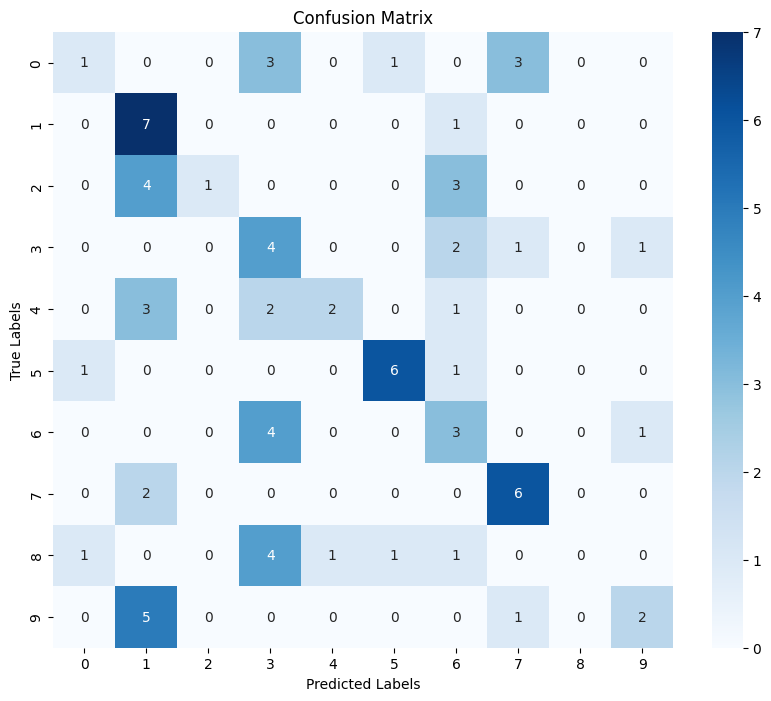

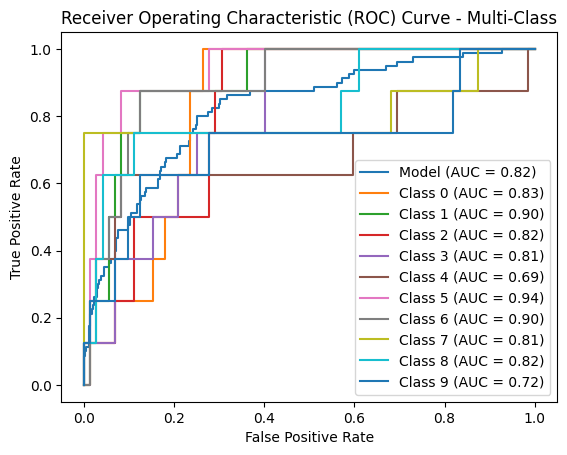

In [ ]:
# Test the model
test(model_1, custom_data_module.test_dataloader())


# K-Fold

In [ ]:
# Set up WandB
wandb.init(project="arch_1_KFold")

# Data Setup
test_samp = 1
batch_size = 32  # Free to change
num_workers = 4  # Free to change

val_accuracies = []
val_losses = []

for valid_samp in range(2, 6):  # Loop over different fold values (2 to 5)
    print("Fold",valid_samp-1)
    custom_data_module = CustomDataModule(batch_size=batch_size,
                                          num_workers=num_workers,
                                          data_directory=path,
                                          data_frame=df,
                                          validation_fold=valid_samp,
                                          testing_fold=test_samp,  # set to 0 for no test set
                                          esc_10_flag=True,
                                          file_column='filename',
                                          label_column='category',
                                          sampling_rate=44100,
                                          new_sampling_rate=16000,  # new sample rate for input
                                          sample_length_seconds=1  # new length of input in seconds
                                          )

    custom_data_module.setup()

    # Create an instance of the CustomConv1DNetwork
    gc.collect()
    torch.cuda.empty_cache()
    model_1_k = Conv1DClassifier(in_channels, conv_channels, conv_kernel_sizes, conv_strides, fc_hidden_size, num_classes)
    model_1_k = model_1_k.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_1_k.parameters(), lr=0.001)
    epochs = 25

    # Training loop
    for epoch in range(epochs):
        train_acc, train_loss = train(model_1_k, custom_data_module.train_dataloader(), criterion, optimizer, epoch)
        val_acc, val_loss  = validate(model_1_k, custom_data_module.val_dataloader(), criterion, epoch)



    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    print("epoch", epoch, "val_loss", val_loss, "val_accuracy", val_acc)
    # Test the model
    # test(model_1_k, custom_data_module.val_dataloader())



# End WandB run
wandb.finish()

# Calculate mean and standard deviation
mean_val_accuracy = np.mean(val_accuracies)
std_val_accuracy = np.std(val_accuracies)
mean_val_loss = np.mean(val_losses)
std_val_loss = np.std(val_losses)

print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f} ± {std_val_accuracy:.4f}")
print(f"Mean Validation Loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")


wandb: Currently logged in as: m23mac008 (dl_assignment_2). Use `wandb login --relogin` to force relogin


Fold 1


100%|██████████| 80/80 [00:00<00:00, 5242.31it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 24 val_loss 1.6505757570266724 val_accuracy 0.3375
Fold 2


100%|██████████| 80/80 [00:00<00:00, 6648.52it/s]


epoch 24 val_loss 1.7835933367411296 val_accuracy 0.35
Fold 3


100%|██████████| 80/80 [00:00<00:00, 8780.66it/s]


epoch 24 val_loss 1.7758946021397908 val_accuracy 0.3875
Fold 4


100%|██████████| 80/80 [00:00<00:00, 4506.91it/s]


epoch 24 val_loss 2.0098085006078086 val_accuracy 0.4


epoch,▁▂▂▃▄▅▅▆▇▇▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███▁▂▄▆▇▇▇█▇█▁▄▅▆▇▇▇▇██▂▄▅▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁█▅▃▂▂▂▁▁▁▁▇▄▃▂▂▂▂▁▁▁▆▄▃▂▂▂▂▁▁▁
val_accuracy,▁▁▃▅▅▅▆▇▆▅▁▂▄▇▇▆▇▆▆▇▁▂▄▅▆▇▇██▇▁▁▄▅▅▅▆▆▆▇
val_loss,▅▆▃▃▁▁▁▁▁▁▆▅▂▂▂▂▁▂▂▁▇▆▃▂▂▁▁▁▁▁█▆▄▄▃▃▃▃▃▃
epoch,24
train_accuracy,0.92083
train_loss,0.26522
val_accuracy,0.4
val_loss,2.00981


Mean Validation Accuracy: 0.3688 ± 0.0258
Mean Validation Loss: 1.8050 ± 0.1295


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy: 0.3875
F1 Score: 0.33205742558828116


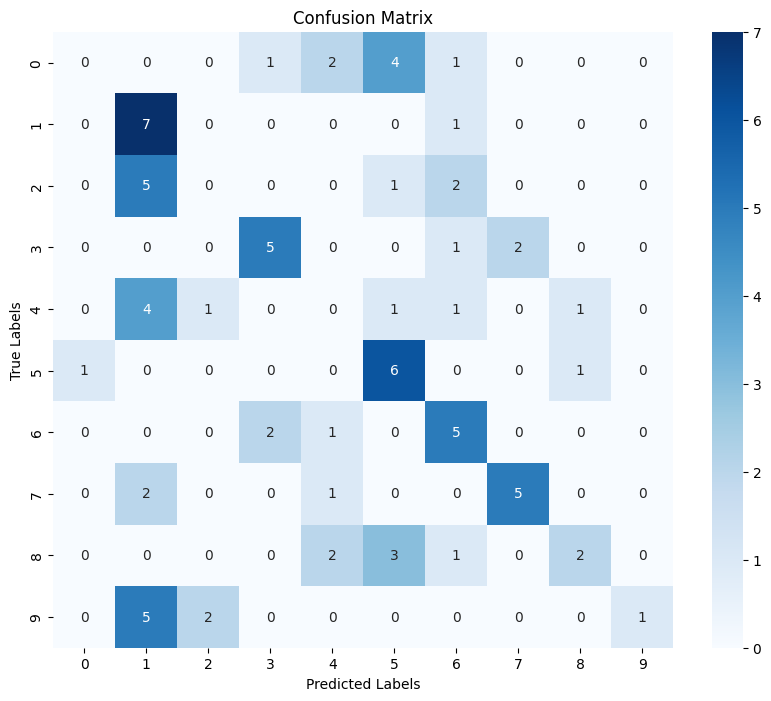

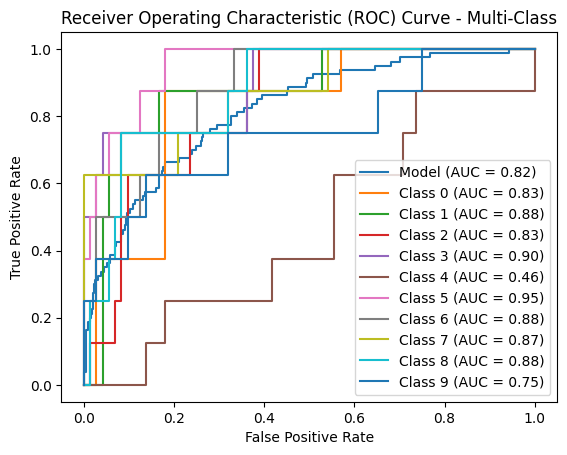

In [ ]:
# Test the model
test(model_1_k, custom_data_module.test_dataloader())

# Total Parameters

In [ ]:
# Report total trainable and non-trainable parameters
total_params = sum(p.numel() for p in model_1.parameters())
trainable_params = sum(p.numel() for p in model_1.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 16402346
Trainable Parameters: 16402346


# Architecture 2


In [ ]:
from convtransformer import ConvTransformerClassifier

# Instantiate the model
input_size = 16000
num_classes = 10
conv_channels = [32, 64, 128]
conv_kernel_sizes = [8, 5, 3]
conv_strides = [1, 1, 1]
embed_size = 128
num_heads = 4
num_transformer_blocks = 2
mlp_hidden_dim = 128
dropout = 0.1




model_2 = ConvTransformerClassifier(input_size, num_classes, conv_channels, conv_kernel_sizes, conv_strides, embed_size, num_heads, num_transformer_blocks, mlp_hidden_dim, dropout)

# Dummy input tensors
input_tensor = torch.randn((32, 9, 16000)).to(device)
model_2 = model_2.to(device)

output = model_2(input_tensor)
print(output.shape)

model_2 = model_2.to(device)

# # Print the model architecture
print(model_2)

torch.Size([32, 10])
ConvTransformerClassifier(
  (conv_blocks): ModuleList(
    (0): Conv1DBlock(
      (conv1d): Conv1d(9, 32, kernel_size=(8,), stride=(1,))
      (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
      (avgpool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (1): Conv1DBlock(
      (conv1d): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
      (avgpool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (2): Conv1DBlock(
      (conv1d): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
      (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
      (avgpool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
  )
  (

In [ ]:
criterion = nn.CrossEntropyLoss()

# Define your optimizer
optimizer = optim.Adam(model_2.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

epochs = 25


In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Set up WandB
wandb.init(project="arch_1")


# Training loop
for epoch in range(epochs):
        train_acc, train_loss = train(model_2, custom_data_module.train_dataloader(), criterion, optimizer, epoch)
        val_acc, val_loss  = validate(model_2, custom_data_module.val_dataloader(), criterion, epoch)

        print("epoch", epoch, "train_loss", train_loss, "train_accuracy", train_acc)
        print("epoch", epoch, "val_loss", val_loss, "val_accuracy", val_acc)


    # Learning rate scheduling step
    # scheduler.step()

# End WandB run
wandb.finish()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 0 train_loss 2.228892043232918 train_accuracy 0.2375
epoch 0 val_loss 3.191344976425171 val_accuracy 0.1
epoch 1 train_loss 1.7966580241918564 train_accuracy 0.32916666666666666
epoch 1 val_loss 2.7069154580434165 val_accuracy 0.1
epoch 2 train_loss 1.5691847950220108 train_accuracy 0.42916666666666664
epoch 2 val_loss 2.567233403523763 val_accuracy 0.1375
epoch 3 train_loss 1.4883551448583603 train_accuracy 0.49583333333333335
epoch 3 val_loss 2.3784143129984536 val_accuracy 0.125
epoch 4 train_loss 1.3626053929328918 train_accuracy 0.4875
epoch 4 val_loss 2.007439057032267 val_accuracy 0.2625
epoch 5 train_loss 1.3047836273908615 train_accuracy 0.5625
epoch 5 val_loss 1.529033939043681 val_accuracy 0.45
epoch 6 train_loss 1.204913429915905 train_accuracy 0.5875
epoch 6 val_loss 1.4312918583552043 val_accuracy 0.4625
epoch 7 train_loss 1.1805761903524399 train_accuracy 0.6166666666666667
epoch 7 val_loss 1.3320353428522747 val_accuracy 0.5
epoch 8 train_loss 1.0863824114203453 t

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇█▇███
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
val_accuracy,▁▁▂▁▃▆▆▇█▇▇▇▇▇█▇██▇▇█▇▇██
val_loss,█▆▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
train_accuracy,0.8375
train_loss,0.53592
val_accuracy,0.575
val_loss,1.25264


Test Accuracy: 0.5375
F1 Score: 0.5082780866476518


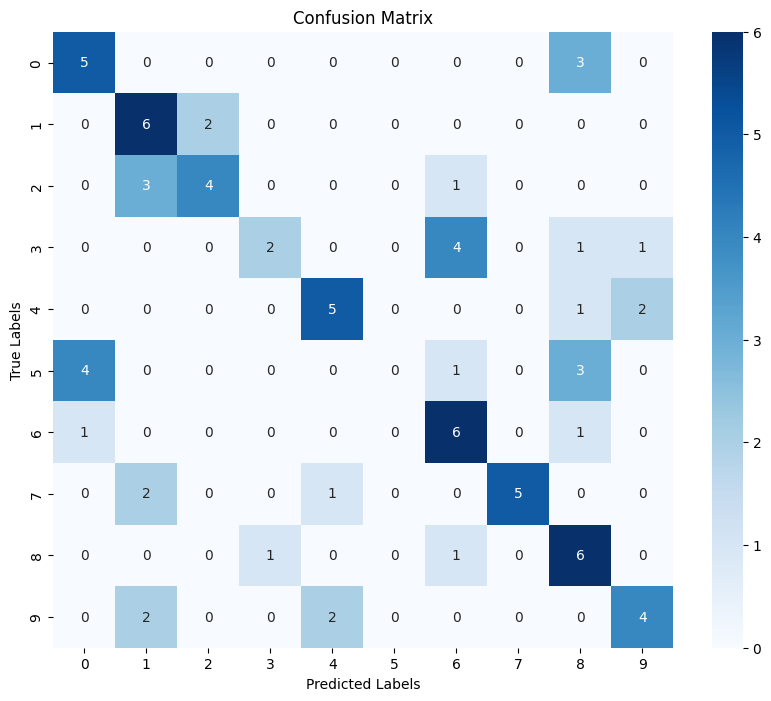

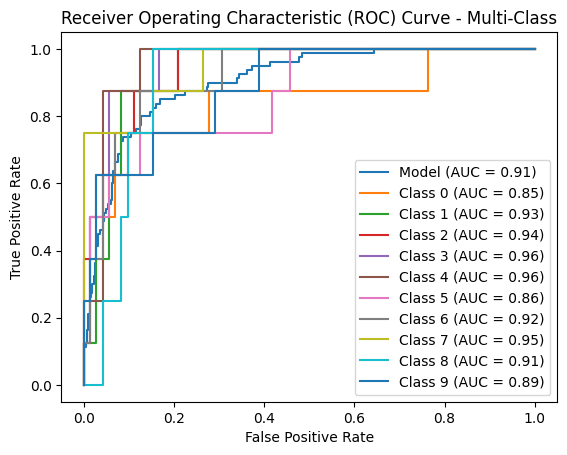

In [ ]:
# Test the model
test(model_2, custom_data_module.test_dataloader())

In [ ]:
input_size = 16000
num_classes = 10
conv_channels = [32, 64, 128]
conv_kernel_sizes = [8, 5, 3]
conv_strides = [1, 1, 1]
embed_size = 128
num_heads = 2
num_transformer_blocks = 2
mlp_hidden_dim = 128
dropout = 0.1


# K-Fold

In [ ]:
# Set up WandB
wandb.init(project="arch_1_KFold")

# Data Setup
test_samp = 1
batch_size = 32  # Free to change
num_workers = 4  # Free to change

val_accuracies = []
val_losses = []

for valid_samp in range(2, 6):  # Loop over different fold values (2 to 5)
    print("Fold",valid_samp-1)
    custom_data_module = CustomDataModule(batch_size=batch_size,
                                          num_workers=num_workers,
                                          data_directory=path,
                                          data_frame=df,
                                          validation_fold=valid_samp,
                                          testing_fold=test_samp,  # set to 0 for no test set
                                          esc_10_flag=True,
                                          file_column='filename',
                                          label_column='category',
                                          sampling_rate=44100,
                                          new_sampling_rate=16000,  # new sample rate for input
                                          sample_length_seconds=1  # new length of input in seconds
                                          )

    custom_data_module.setup()

    # Create an instance of the CustomConv1DNetwork
    gc.collect()
    torch.cuda.empty_cache()
    model_2_k = ConvTransformerClassifier(input_size, num_classes, conv_channels, conv_kernel_sizes, conv_strides, embed_size, num_heads, num_transformer_blocks, mlp_hidden_dim, dropout)
    model_2_k = model_2_k.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_2_k.parameters(), lr=0.0001)
    epochs = 25

    # Training loop
    for epoch in range(epochs):
        train_acc, train_loss = train(model_2_k, custom_data_module.train_dataloader(), criterion, optimizer, epoch)
        val_acc, val_loss  = validate(model_2_k, custom_data_module.val_dataloader(), criterion, epoch)



    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    print("Fold",valid_samp-1, "val_loss", val_loss, "val_accuracy", val_acc)
    # Test the model
    # test(model_2_k, custom_data_module.val_dataloader())



# End WandB run
wandb.finish()

# Calculate mean and standard deviation
mean_val_accuracy = np.mean(val_accuracies)
std_val_accuracy = np.std(val_accuracies)
mean_val_loss = np.mean(val_losses)
std_val_loss = np.std(val_losses)

print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f} ± {std_val_accuracy:.4f}")
print(f"Mean Validation Loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")


Fold 1


100%|██████████| 80/80 [00:00<00:00, 5999.79it/s]


Fold 1 val_loss 1.3950443665186565 val_accuracy 0.4875
Fold 2


100%|██████████| 80/80 [00:00<00:00, 7928.93it/s]


Fold 2 val_loss 1.4219205776850383 val_accuracy 0.5
Fold 3


100%|██████████| 80/80 [00:00<00:00, 8735.40it/s]


Fold 3 val_loss 1.1116108099619548 val_accuracy 0.6
Fold 4


100%|██████████| 80/80 [00:00<00:00, 8995.59it/s]


Fold 4 val_loss 1.2588826815287273 val_accuracy 0.525


epoch,▁▂▂▃▄▅▅▆▇▇▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▆▇▇█▇▁▄▅▆▆▇▇▇██▁▄▅▅▆▆▆▆▇▇▂▄▅▆▆▆▇▇▇█
train_loss,▇▅▄▃▃▃▂▂▂▂█▅▄▃▃▂▂▂▂▁█▅▄▃▃▂▂▂▁▁▇▅▄▄▃▃▂▂▂▁
val_accuracy,▁▁▅▆▅▆▆▆▆▆▁▂▆▆▅▆▆▆▆▆▁▃▅▇▇▇█▇█▇▂▂▆▆▆▆▇▇▆▆
val_loss,▇█▄▃▂▂▂▂▂▂▆▅▃▂▂▂▂▂▂▂▆▆▃▂▁▁▁▁▁▁▆▅▂▂▂▂▂▂▂▂
epoch,24
train_accuracy,0.84167
train_loss,0.55851
val_accuracy,0.525
val_loss,1.25888


Mean Validation Accuracy: 0.5281 ± 0.0436
Mean Validation Loss: 1.2969 ± 0.1235


Test Accuracy: 0.575
F1 Score: 0.5745524728109868


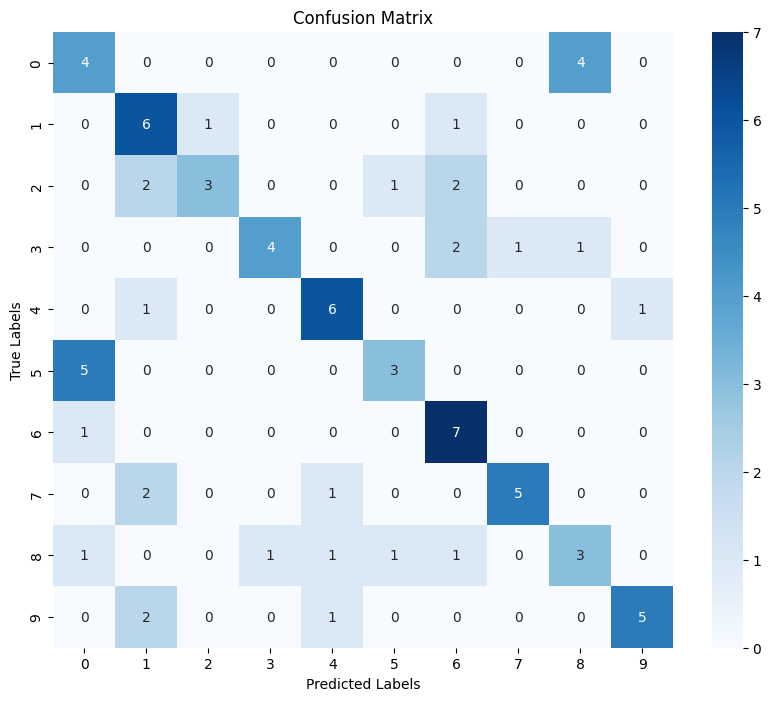

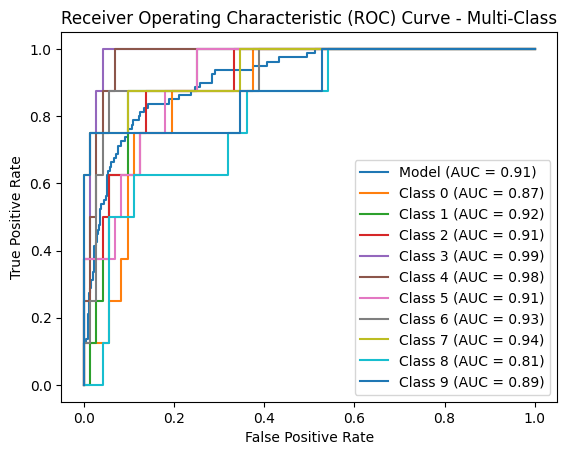

In [ ]:
# Test the model
test(model_2_k, custom_data_module.test_dataloader())

In [ ]:

# Report total trainable and non-trainable parameters
total_params = sum(p.numel() for p in model_2.parameters())
trainable_params = sum(p.numel() for p in model_2.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 452522
Trainable Parameters: 452522


# Hyperparameter Tuning

**Do not run takes lot of time**

In [ ]:
# Define hyperparameters to tune
learning_rates = [0.001, 0.01, 0.1]
dropout_rates = [0.2, 0.3, 0.4]
batch_sizes = [32, 64, 128]


best_accuracy = 0.0
best_hyperparameters = {}

for lr in learning_rates:
        for batch_size in batch_sizes:
            model = Conv1DClassifier(in_channels, conv_channels, conv_kernel_sizes, conv_strides, fc_hidden_size, num_classes)

            # Define your optimizer with the current learning rate
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Data Setup
            test_samp = 1 #  """ Do not change this!! """
            valid_samp = 4 # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
            batch_size = batch_size # Free to change
            num_workers = 4 # Free to change
            custom_data_module = CustomDataModule(batch_size=batch_size,
                                                  num_workers=num_workers,
                                                  data_directory=path,
                                                  data_frame=df,
                                                  validation_fold=valid_samp,
                                                  testing_fold=test_samp,  # set to 0 for no test set
                                                  esc_10_flag=True,
                                                  file_column='filename',
                                                  label_column='category',
                                                  sampling_rate=44100,
                                                  new_sampling_rate=16000,  # new sample rate for input
                                                  sample_length_seconds=1  # new length of input in seconds
                                                  )

            custom_data_module.setup()

            criterion = nn.CrossEntropyLoss()

            epochs = 25

            # Set up WandB
            wandb.init(project="arch_1")

            # Training loop
            for epoch in range(epochs):
                    train_acc, train_loss = train(model_1, custom_data_module.train_dataloader(), criterion, optimizer, epoch)
                    val_acc, val_loss  = validate(model_1, custom_data_module.val_dataloader(), criterion, epoch)

                    # Update best hyperparameters if the current setup is better
                    if val_acc > best_accuracy:
                        best_accuracy = val_acc
                        best_hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}
            # End WandB run
            wandb.finish()

print("Best Hyperparameters:", best_hyperparameters)


100%|██████████| 80/80 [00:00<00:00, 8631.37it/s]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▅▃▁▄▂▇▆▁▄▂▃▄▇▅▄▃▅▆▄▇█▄▂▁▄
train_loss,▄▄▆▅█▁▄▅▃▆▃▄▂▂▆▄▃▆▆▃▁▆▄▆▄
val_accuracy,██▃▆▆▃▃█▃▃▃▃▆▆▆▆▆█▆▆▃▁▆▃█
val_loss,▅▇█▇▇█▇▆▆▅▅▆▃▅▆▆▆▇▇▇▅▇▃▆▁
epoch,24
train_accuracy,0.89583
train_loss,0.3085
val_accuracy,0.35
val_loss,1.84432


100%|██████████| 80/80 [00:00<00:00, 9730.43it/s]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▆▂▄▅▃▄▃▂▆▃▇▆▆▄▆▄▆▆▅█▄▆▅▇▁
train_loss,▃▅▆▅▆▇▇█▄▇▄▄▃▆▁▃▁▄▇▂▅▅▄▄█
val_accuracy,▆▄▄▆▆▆█▆█▄▄▆▆▆█▆▆█▆▄▃▁▄▆▆
val_loss,▁▂▄▅▅▄▅▆▅▇▆▅▄▃▅▅▆▇▆▇▇██▇▅
epoch,24
train_accuracy,0.875
train_loss,0.343
val_accuracy,0.3375
val_loss,1.84017


100%|██████████| 80/80 [00:00<00:00, 10113.76it/s]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▆▆▇▅▆▃▄▆▄▅▆█▂▇▁▄█▆▄▇▅▇▆▅▆
train_loss,▅▂▂▄▃▇▇▁▇▃▄▃▅▁█▆▃▃▇▇▄▁▃▅▃
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▄▆▇██▇▅▄▃▃▂▁▂▂▂▂▅▅▅▅▃▁▂
epoch,24
train_accuracy,0.925
train_loss,0.26302
val_accuracy,0.3375
val_loss,1.88328


100%|██████████| 80/80 [00:00<00:00, 9729.87it/s]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▄▅▄█▆▆▆▄▆▇▅▁▅▁▇▄▆▃▅▆▄▆▅▂▅
train_loss,▄▄▄▁▃▅▅▄▃▃▃█▃▄▂█▅▆▃▃▅▄▅▇▃
val_accuracy,▅▅███▅█▅▅▅█▁▁█▁▁▁▅▅████▁▁
val_loss,▁▃▂▄▃▄▅▅▄▃▅▆▄▃▃▃▅▅▅█▇▇▇▆▇
epoch,24
train_accuracy,0.89583
train_loss,0.29324
val_accuracy,0.325
val_loss,1.9072


100%|██████████| 80/80 [00:00<00:00, 8875.89it/s]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,█▄▄▅▃▆▂▂▇▇▇▃▇▃▄▁█▃▅▆▄█▁▄█
train_loss,▂▅▄▄▃▃▅▆▄▂▄▃▃▃▃█▂▅▃▂▄▁▇▆▃
val_accuracy,▃▁▃█▆▃▃▆▆▁▃▃█▁▃▃▃▃▃▃▃▃▃▃▃
val_loss,█▇▅▇▄▄▅▆▅▄▄▃▆▅▄▄▃▄▂▂▂▂▁▃▃
epoch,24
train_accuracy,0.92917
train_loss,0.28003
val_accuracy,0.3375
val_loss,1.84201


100%|██████████| 80/80 [00:00<00:00, 9133.69it/s]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▆▅▁▂▃▆▇▆▅▆█▄▁▄▆▄▇▄█▅▅▅▅▇█
train_loss,▃▅██▅▇▂▄▄▄▁▆█▅▄▅▁▃▂▃▅▅▃▃▁
val_accuracy,▅▅▅▅▅▅▅▁▁▁▁▅▅▅▅█▅▅▁▅▅▅▁▁▁
val_loss,▅▅▁▃▄▄▄▆▇█▇▆▃▄▆▆▄▅▄▄▄▄▄▄▅
epoch,24
train_accuracy,0.9375
train_loss,0.23479
val_accuracy,0.325
val_loss,1.88148


100%|██████████| 80/80 [00:00<00:00, 8761.86it/s]


KeyboardInterrupt: 

In [ ]:
best_hyperparameters

{'learning_rate': 0.001, 'batch_size': 32}